# 1. Mount virtual drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Importing libraries

In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from pandas import ExcelWriter
from sklearn.metrics import accuracy_score, recall_score, auc, roc_curve, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

In [79]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(9, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# 3. Loading datasets

In [6]:
train_df = pd.read_csv("/content/drive/My Drive/train.csv",encoding = 'ISO-8859-1')
test_df = pd.read_csv("/content/drive/MyDrive/test.csv")
address_df = pd.read_csv("/content/drive/MyDrive/addresses.csv")

train_df.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,non_us_str_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,IL,60606,NaN,USA,2004-03-16 11:40:00,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,MI,48208,NaN,USA,2004-04-23 12:30:00,2005-05-06 13:30:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Determination,750.0,20.0,10.0,75.0,0.0,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,MI,48223,NaN,USA,2004-04-26 13:40:00,2005-03-29 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
3,22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441.0,LONGFELLOW,NaN,5.0,ST. CLAIR,DETROIT,MI,48214,NaN,USA,2004-04-26 13:30:00,NaN,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by City Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
4,22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449.0,CHURCHILL,NaN,7449.0,CHURCHILL,DETROIT,MI,48206,NaN,USA,2004-04-26 13:00:00,2005-03-29 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN


In [7]:
train_df.shape

(250306, 34)

# 4. Data cleaning and wrangling

### 4.1 Dropping variables that don't provide much information

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250306 entries, 0 to 250305
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ticket_id                   250306 non-null  int64  
 1   agency_name                 250306 non-null  object 
 2   inspector_name              250306 non-null  object 
 3   violator_name               250272 non-null  object 
 4   violation_street_number     250306 non-null  float64
 5   violation_street_name       250306 non-null  object 
 6   violation_zip_code          0 non-null       float64
 7   mailing_address_str_number  246704 non-null  float64
 8   mailing_address_str_name    250302 non-null  object 
 9   city                        250306 non-null  object 
 10  state                       250213 non-null  object 
 11  zip_code                    250305 non-null  object 
 12  non_us_str_code             3 non-null       object 
 13  country       

In [9]:
train_df = train_df.drop(['ticket_id','country','payment_date','payment_status','collection_status',
                          'grafitti_status','compliance_detail','violation_zip_code','non_us_str_code',
                          'payment_amount','late_fee','balance_due','state'],axis=1)
test_df = test_df.drop(['ticket_id','country','grafitti_status','violation_zip_code','non_us_str_code',
                        'late_fee','state'],axis=1)
train_df.head()

,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,mailing_address_str_number,mailing_address_str_name,city,zip_code,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,discount_amount,clean_up_cost,judgment_amount,compliance
0,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,3.0,S. WICKER,CHICAGO,60606,2004-03-16 11:40:00,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,0.0,0.0,305.0,0.0
1,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,2959.0,Martin Luther King,Detroit,48208,2004-04-23 12:30:00,2005-05-06 13:30:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Determination,750.0,20.0,10.0,0.0,0.0,855.0,1.0
2,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,23658.0,P.O. BOX,DETROIT,48223,2004-04-26 13:40:00,2005-03-29 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,NaN
3,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441.0,LONGFELLOW,5.0,ST. CLAIR,DETROIT,48214,2004-04-26 13:30:00,NaN,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by City Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,NaN
4,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449.0,CHURCHILL,7449.0,CHURCHILL,DETROIT,48206,2004-04-26 13:00:00,2005-03-29 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,NaN


### 4.2 Dropping variables with too many unique values

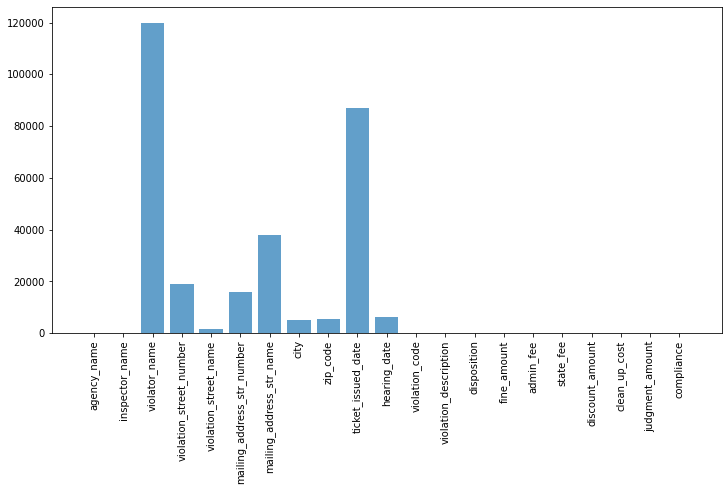

In [10]:
unique_lens = []
for var in train_df.columns:
  #print (var,len(train_df[var].unique()))
  unique_lens.append(len(train_df[var].unique()))

plt.figure(figsize=(12,6))
plt.bar(train_df.columns,unique_lens,alpha=0.7)
plt.xticks(rotation=90)
plt.show()

In [11]:
#Exploring the unique values for categorical variables that have relatively lower categories
print (len(train_df['violation_code'].unique()))
print (len(train_df['violation_description'].unique()))
print (len(train_df['violation_street_name'].unique()))
print (len(train_df['disposition'].unique()))
print (len(train_df['zip_code'].unique()))
print (len(train_df['inspector_name'].unique()))

235
258
1791
9
5643
173


Variables that contain too many unique values to be useful for prediction: 

1. violator_name
2. violation_street_number
3. mailing_address_str_number
4. mailing_address_str_name
5. violation_street_name
6. violation_code
7. violation_description
8. zip_code

Note: We can keep *ticket_issued_date* since we will be using it later for feature engineering. 


In [12]:
train_df = train_df.drop(['violator_name','violation_street_number','mailing_address_str_number',
                          'mailing_address_str_name','violation_street_name',
                          'violation_code','violation_description','zip_code','inspector_name'],axis=1)
test_df = test_df.drop(['violator_name','violation_street_number','mailing_address_str_number',
                          'mailing_address_str_name','violation_street_name',
                          'violation_code','violation_description','zip_code','inspector_name'],axis=1)
train_df.head()

,agency_name,city,ticket_issued_date,hearing_date,disposition,fine_amount,admin_fee,state_fee,discount_amount,clean_up_cost,judgment_amount,compliance
0,"Buildings, Safety Engineering & Env Department",CHICAGO,2004-03-16 11:40:00,2005-03-21 10:30:00,Responsible by Default,250.0,20.0,10.0,0.0,0.0,305.0,0.0
1,"Buildings, Safety Engineering & Env Department",Detroit,2004-04-23 12:30:00,2005-05-06 13:30:00,Responsible by Determination,750.0,20.0,10.0,0.0,0.0,855.0,1.0
2,"Buildings, Safety Engineering & Env Department",DETROIT,2004-04-26 13:40:00,2005-03-29 10:30:00,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,NaN
3,"Buildings, Safety Engineering & Env Department",DETROIT,2004-04-26 13:30:00,NaN,Not responsible by City Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,NaN
4,"Buildings, Safety Engineering & Env Department",DETROIT,2004-04-26 13:00:00,2005-03-29 10:30:00,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,NaN


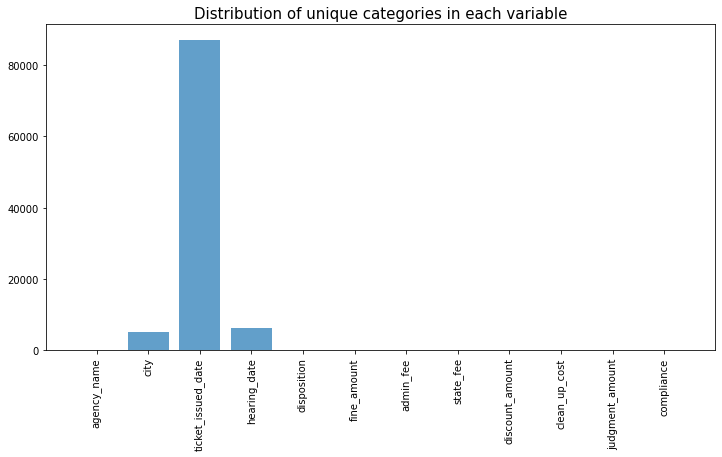

In [13]:
unique_lens = []
for var in train_df.columns:
  #print (var,len(train_df[var].unique()))
  unique_lens.append(len(train_df[var].unique()))

plt.figure(figsize=(12,6))
plt.bar(train_df.columns,unique_lens,alpha=0.7)
plt.xticks(rotation=90)
plt.title('Distribution of unique categories in each variable',size=15)
plt.show()

# 5. Cleaning and wrangling

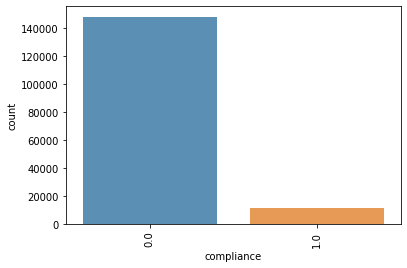

In [14]:
sns.countplot(data=train_df,x='compliance',alpha=0.8)
plt.xticks(rotation=90)
plt.show()

In [15]:
#Changing all city entries to upper case to make it simpler
train_df["city"] = train_df["city"].apply(str.upper)

#Filtering tickets only for the city of Detroit and then dropping the 'city' variable 
#since all instances would be for Detroit
train_df = train_df[train_df["city"]=="DETROIT"]
train_df = train_df.drop(["city"],axis=1)
test_df = test_df.drop(["city"],axis=1)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151621 entries, 1 to 250305
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   agency_name         151621 non-null  object 
 1   ticket_issued_date  151621 non-null  object 
 2   hearing_date        145058 non-null  object 
 3   disposition         151621 non-null  object 
 4   fine_amount         151620 non-null  float64
 5   admin_fee           151621 non-null  float64
 6   state_fee           151621 non-null  float64
 7   discount_amount     151621 non-null  float64
 8   clean_up_cost       151621 non-null  float64
 9   judgment_amount     151621 non-null  float64
 10  compliance          96001 non-null   float64
dtypes: float64(7), object(4)
memory usage: 13.9+ MB


In [16]:
train_df['compliance'].isnull().sum()

55620

In [17]:
#Removing all 'not found responsible' compliance entries
train_df = train_df[(train_df["compliance"]==1.0) | (train_df["compliance"]==0.0)]

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96001 entries, 1 to 250290
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   agency_name         96001 non-null  object 
 1   ticket_issued_date  96001 non-null  object 
 2   hearing_date        95884 non-null  object 
 3   disposition         96001 non-null  object 
 4   fine_amount         96001 non-null  float64
 5   admin_fee           96001 non-null  float64
 6   state_fee           96001 non-null  float64
 7   discount_amount     96001 non-null  float64
 8   clean_up_cost       96001 non-null  float64
 9   judgment_amount     96001 non-null  float64
 10  compliance          96001 non-null  float64
dtypes: float64(7), object(4)
memory usage: 8.8+ MB


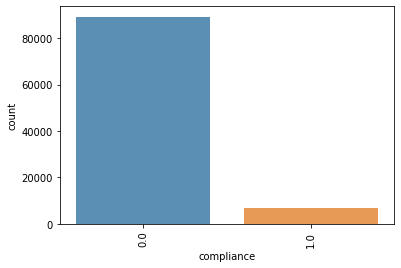

In [18]:
sns.countplot(data=train_df,x='compliance',alpha=0.8)
plt.xticks(rotation=90)
plt.show()

# 5. EDA

### 5.1 Categorical variables

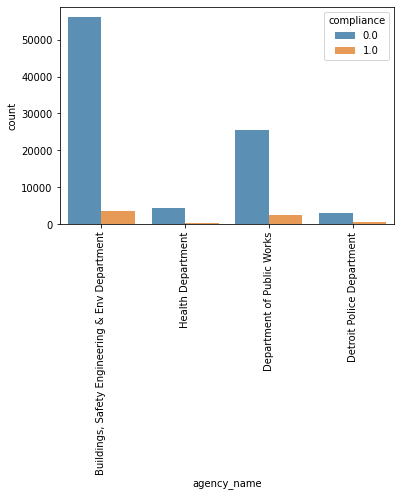

In [19]:
sns.countplot(data=train_df,x='agency_name',hue='compliance',alpha=0.8)
plt.xticks(rotation=90)
plt.show()

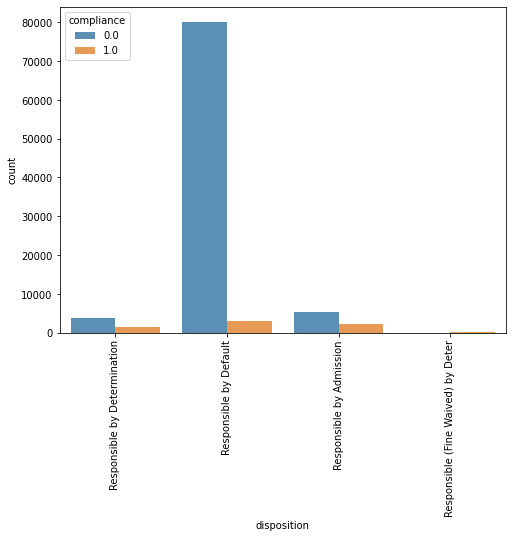

In [20]:
plt.figure(figsize=(8,6))
sns.countplot(data=train_df,x='disposition',hue='compliance',alpha=0.8)
plt.xticks(rotation=90)
plt.show()

In [21]:
train_df[['disposition','compliance','fine_amount']].groupby(['disposition','compliance']).count()

fine_amount
disposition                        compliance             
Responsible (Fine Waived) by Deter 1.0                 136
Responsible by Admission           0.0                5444
                                   1.0                2230
Responsible by Default             0.0               80046
                                   1.0                2957
Responsible by Determination       0.0                3669
                                   1.0                1519

### 5.2 Numerical variables

In [22]:
train_df.columns

Index(['agency_name', 'ticket_issued_date', 'hearing_date', 'disposition',
       'fine_amount', 'admin_fee', 'state_fee', 'discount_amount',
       'clean_up_cost', 'judgment_amount', 'compliance'],
      dtype='object')

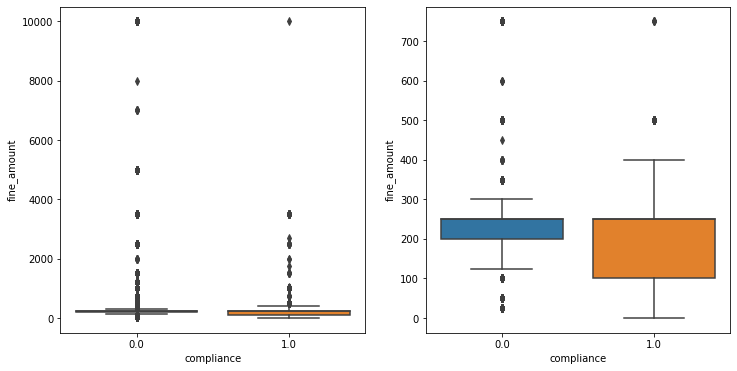

In [23]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.boxplot(data=train_df,y='fine_amount',x='compliance')
plt.subplot(1,2,2)
sns.boxplot(data=train_df[train_df['fine_amount']<1000],y='fine_amount',x='compliance')

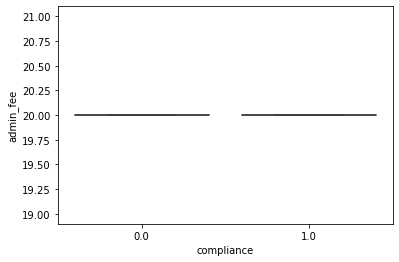

In [24]:
sns.boxplot(data=train_df,y='admin_fee',x='compliance')

(array([    0.,     0.,     0.,     0.,     0., 96001.,     0.,     0.,
            0.,     0.]),
 array([19.5, 19.6, 19.7, 19.8, 19.9, 20. , 20.1, 20.2, 20.3, 20.4, 20.5]),
 <a list of 10 Patch objects>)

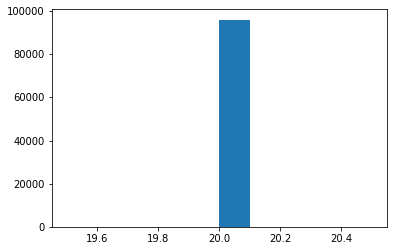

In [25]:
plt.hist(train_df['admin_fee'])

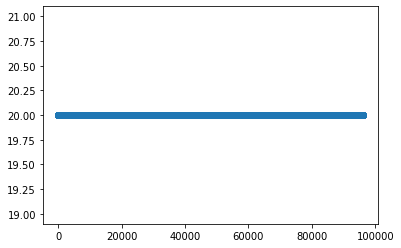

In [26]:
plt.scatter(range(len(train_df['admin_fee'])),train_df['admin_fee'])

All the admin fees have a value of 20 so this variable doesn't provide much useful information for prediction. 

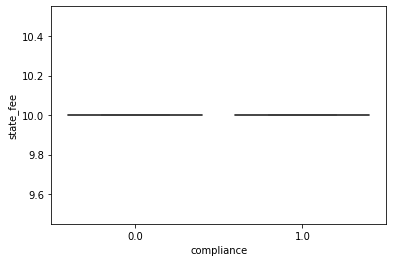

In [27]:
sns.boxplot(data=train_df,y='state_fee',x='compliance')

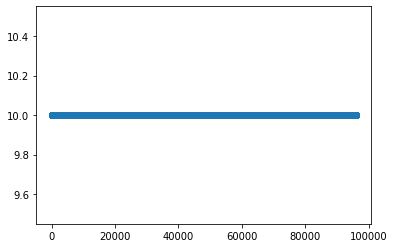

In [28]:
plt.scatter(range(len(train_df['state_fee'])),train_df['state_fee'])

Same issue as admin fee. 

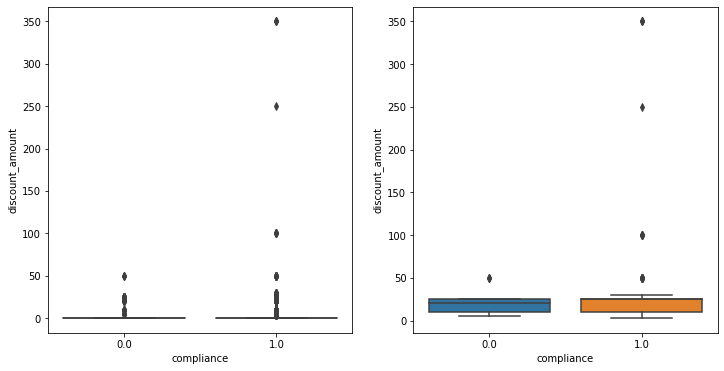

In [29]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.boxplot(data=train_df,y='discount_amount',x='compliance')
plt.subplot(1,2,2)
sns.boxplot(data=train_df[train_df['discount_amount']!=0],y='discount_amount',x='compliance')

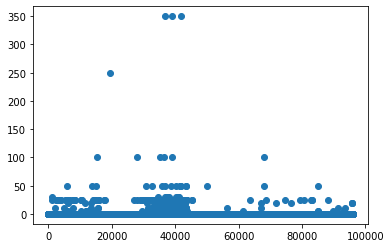

In [30]:
plt.scatter(range(len(train_df['discount_amount'])),train_df['discount_amount'])

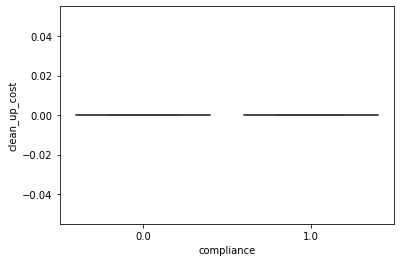

In [31]:
sns.boxplot(data=train_df,y='clean_up_cost',x='compliance')

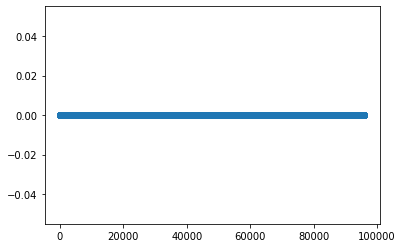

In [32]:
plt.scatter(range(len(train_df['clean_up_cost'])),train_df['clean_up_cost'])

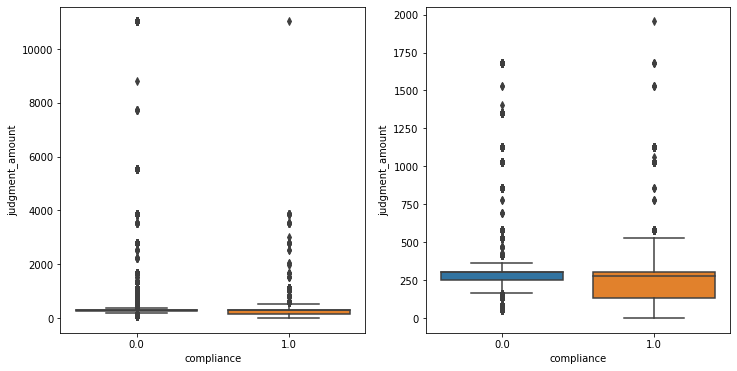

In [33]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.boxplot(data=train_df,y='judgment_amount',x='compliance')
plt.subplot(1,2,2)
sns.boxplot(data=train_df[train_df['judgment_amount']<2000],y='judgment_amount',x='compliance')

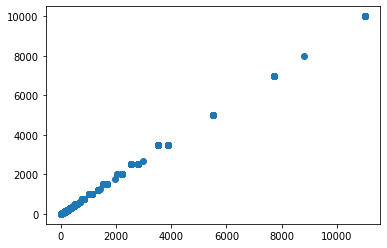

In [34]:
plt.scatter(train_df['judgment_amount'],train_df['fine_amount'])

In [35]:
np.corrcoef(train_df['judgment_amount'],train_df['fine_amount'])

array([[1.        , 0.99990275],
       [0.99990275, 1.        ]])

The variable *fine_amount* and *judgement_amount* are highly correlated and keeping both variables may not provide a lot more information to the model. 

# 5. Data pre-processing

### 5.1 Feature selection

In [36]:
train_df = train_df.drop(['admin_fee','state_fee','clean_up_cost'],axis=1)
test_df = test_df.drop(['admin_fee','state_fee','clean_up_cost'],axis=1)
train_df.head()

,agency_name,ticket_issued_date,hearing_date,disposition,fine_amount,discount_amount,judgment_amount,compliance
1,"Buildings, Safety Engineering & Env Department",2004-04-23 12:30:00,2005-05-06 13:30:00,Responsible by Determination,750.0,0.0,855.0,1.0
7,"Buildings, Safety Engineering & Env Department",2004-06-16 12:30:00,2005-02-22 15:00:00,Responsible by Default,100.0,0.0,140.0,0.0
8,"Buildings, Safety Engineering & Env Department",2004-06-16 12:25:00,2005-02-22 15:00:00,Responsible by Default,100.0,0.0,140.0,0.0
9,"Buildings, Safety Engineering & Env Department",2004-07-12 13:30:00,2005-05-31 13:30:00,Responsible by Default,750.0,0.0,855.0,0.0
12,"Buildings, Safety Engineering & Env Department",2004-07-28 12:15:00,2005-02-22 15:00:00,Responsible by Default,750.0,0.0,855.0,0.0


### 5.2 Feature engineering

In [37]:
#Creating a new variable for storing the time difference between the ticket issued date and hearing date
#And converting the difference into days for easier calculation
train_df["ticket_issued_date"] = train_df.apply(lambda x: pd.to_datetime(x[1]),axis=1)
train_df["hearing_date"] = train_df.apply(lambda x: pd.to_datetime(x[2]),axis=1)
test_df["ticket_issued_date"] = test_df.apply(lambda x: pd.to_datetime(x[1]),axis=1)
test_df["hearing_date"] = test_df.apply(lambda x: pd.to_datetime(x[2]),axis=1)
train_df["time_to_hearing"] = train_df["hearing_date"] - train_df["ticket_issued_date"]
test_df["time_to_hearing"] = test_df["hearing_date"] - test_df["ticket_issued_date"]

test_df["time_to_hearing"] = test_df["time_to_hearing"].map(str)
test_df["time_to_hearing"] = test_df["time_to_hearing"].replace('NaT',str(pd.Timestamp('1/1/18')-pd.Timestamp('1/1/18')))
test_df["time_to_hearing"] = test_df["time_to_hearing"].map(pd.Timedelta)

train_df["time_to_hearing"] = train_df["time_to_hearing"].apply(lambda x: x.days)
test_df["time_to_hearing"] = test_df["time_to_hearing"].apply(lambda x: x.days)

#Separating the 'ticket_id' column
#ticket_id_train = train_df["ticket_id"]
#ticket_id_test = test_df["ticket_id"]
#train_df = train_df.drop(["ticket_id"],axis=1)
#test_df = test_df.drop(["ticket_id"],axis=1)

In [38]:
print (train_df.head())
print (train_df.shape)

                                       agency_name  ... time_to_hearing
1   Buildings, Safety Engineering & Env Department  ...           378.0
7   Buildings, Safety Engineering & Env Department  ...           251.0
8   Buildings, Safety Engineering & Env Department  ...           251.0
9   Buildings, Safety Engineering & Env Department  ...           323.0
12  Buildings, Safety Engineering & Env Department  ...           209.0

[5 rows x 9 columns]
(96001, 9)


### 5.3 Handling missing values

In [39]:
#Dropping all the 'Nan' instances from the training set
train_df = train_df.dropna()

#Removing original time variables
train_df = train_df.drop(["ticket_issued_date","hearing_date"],axis=1)
test_df = test_df.drop(["ticket_issued_date","hearing_date"],axis=1)

In [40]:
train_df.index = range(train_df.shape[0])

### 5.4 Label encoding

In [41]:
#Label encoding categorical variables
le = LabelEncoder()
ohe = OneHotEncoder()

le.fit(train_df["agency_name"].append(test_df["agency_name"]))
train_df["agency_name"] = le.transform(train_df["agency_name"])
test_df["agency_name"] = le.transform(test_df["agency_name"])

le.fit(train_df["disposition"].append(test_df["disposition"]))
train_df["disposition"] = le.transform(train_df["disposition"])
test_df["disposition"] = le.transform(test_df["disposition"])

### 5.5 Data preparation

In [42]:
#Splitting the training dataset into features and target variables
y = train_df["compliance"]
x = train_df.drop(["compliance"],axis=1)

#Train/Test Split
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=0)

#Normalization using MinMax scaler
#scaler = MinMaxScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

#for i in [0.1]:
#    for j in [25,30,35,40,45,50]:
#        for k in [5,6,7,8,9,10]:

print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)

(71913, 6)
(23971, 6)
(71913,)
(23971,)


# 6. Modeling

In [78]:
def model_predict(model,x_train,x_test,y_train,y_test):  
  #model = LogisticRegression(random_state=0,C=1)
  model = model.fit(x_train,y_train)
  prediction = model.predict(x_test)

  lr_probs = model.predict_proba(x_test)
  # keep probabilities for the positive outcome only
  lr_probs_pos = lr_probs[:,1]
  lr_probs_neg = lr_probs[:,0]

  # calculate scores
  lr_auc = roc_auc_score(y_test, prediction)
  lr_auc_pos = roc_auc_score(y_test, lr_probs_pos)
  lr_auc_neg = roc_auc_score(y_test, lr_probs_neg)

  # summarize scores
  print('Combined ROC AUC=%.3f' % (lr_auc))
  print('Severe class ROC AUC=%.3f' % (lr_auc_pos))
  print('Not severe class ROC AUC=%.3f' % (lr_auc_neg))

  lr_fpr, lr_tpr, thresh = roc_curve(y_test, prediction)
  lr_fpr_neg, lr_tpr_neg, thresh = roc_curve(y_test, lr_probs[:,0])
  lr_fpr_pos, lr_tpr_pos, thresh = roc_curve(y_test, lr_probs_pos)

  tn, fp, fn, tp = confusion_matrix(y_test.values, prediction).ravel()

  print ("ROC AUC: ",lr_auc_pos)
  print ("Accuracy: ",accuracy_score(y_test.values,prediction))
  print ("Precision: ",precision_score(y_test.values,prediction))
  print ("Recall: ",recall_score(y_test.values,prediction))
  print ("F1 score: ",f1_score(y_test.values,prediction))

  plot_confusion_matrix(cm           = np.array([[ tp,  fn],
                                                [  fp, tn]]), 
                        normalize    = False,
                        target_names = ['Compliance', 'Non-compliance'],
                        title        = "Confusion Matrix")
  
  plt.figure(figsize=(9,7))
  # plot the roc curve for the model
  plt.plot(lr_fpr, lr_tpr, marker='.', label='Combined')
  plt.plot(lr_fpr_neg, lr_tpr_neg, marker='.', label='Not severe class')
  plt.plot(lr_fpr_pos, lr_tpr_pos, marker='.', label='Severe class')
  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  # show the legend
  plt.legend()
  # show the plot
  plt.show()

### 6.1 Baseline model - Logistic regression

In [45]:
x_train_preprocessed = pd.get_dummies(x_train,columns=['disposition','agency_name'])
x_test_preprocessed = pd.get_dummies(x_test,columns=['disposition','agency_name'])

x_train_preprocessed

,fine_amount,discount_amount,judgment_amount,time_to_hearing,disposition_1,disposition_4,disposition_5,disposition_6,agency_name_0,agency_name_1,agency_name_2,agency_name_3
8388,250.0,0.0,305.0,180.0,0,0,1,0,1,0,0,0
67311,50.0,0.0,85.0,144.0,0,0,1,0,0,1,0,0
72134,1000.0,0.0,1130.0,109.0,0,0,1,0,0,1,0,0
41895,200.0,0.0,250.0,40.0,0,0,1,0,0,1,0,0
28332,3500.0,0.0,3880.0,15.0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
21243,200.0,0.0,250.0,16.0,0,0,1,0,0,0,0,1
45891,250.0,0.0,305.0,41.0,0,0,1,0,1,0,0,0
42613,250.0,0.0,305.0,63.0,0,0,1,0,1,0,0,0
43567,2500.0,0.0,2780.0,27.0,0,0,1,0,0,1,0,0


In [46]:
#Normalization using MinMax scaler
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train_preprocessed)
x_test_scaled = scaler.transform(x_test_preprocessed)

Combined ROC AUC=0.555
Severe class ROC AUC=0.779
Not severe class ROC AUC=0.221
ROC AUC:  0.7794145590707002
Accuracy:  0.9359225731091736
Precision:  0.8068669527896996
Recall:  0.11197141155449672
F1 score:  0.19665271966527195


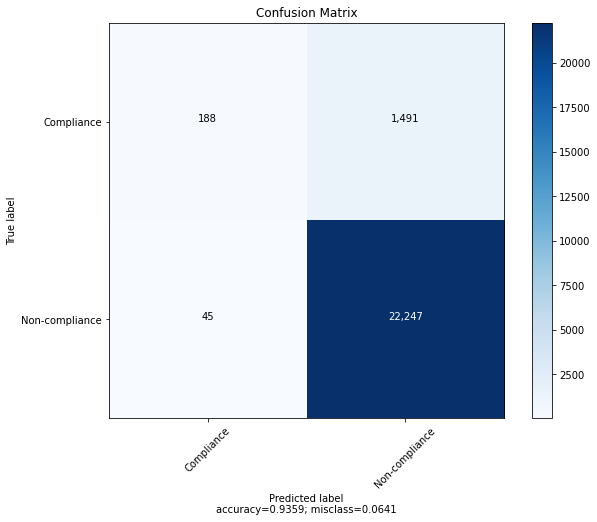

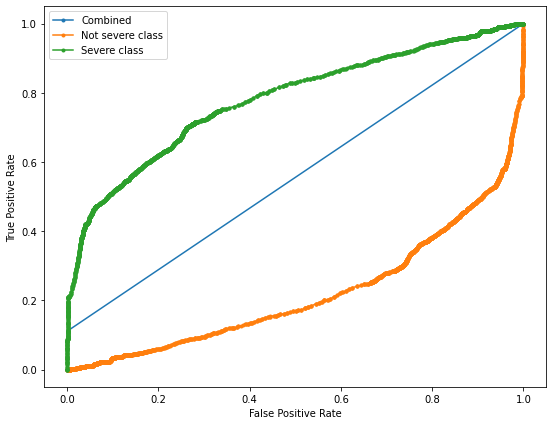

In [80]:
model_predict(LogisticRegression(random_state=0,C=1),x_train,x_test,y_train,y_test)

#### 6.1.1 With scaling and preprocessing

Combined ROC AUC=0.513
Severe class ROC AUC=0.774
Not severe class ROC AUC=0.226
ROC AUC:  0.7741428216769207
Accuracy:  0.9317508656293021
Precision:  0.9777777777777777
Recall:  0.026206075044669448
F1 score:  0.05104408352668214


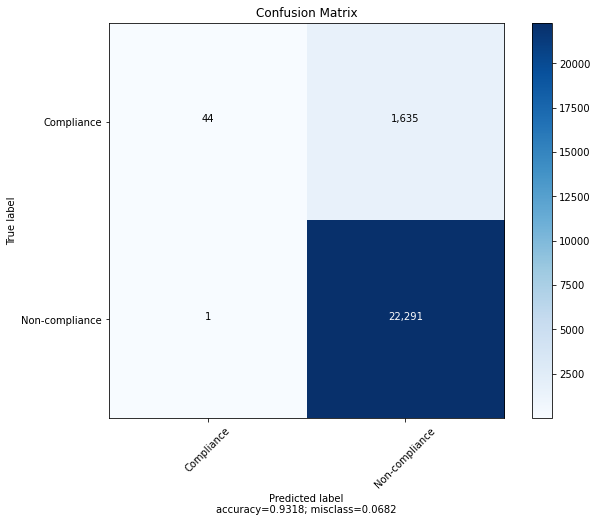

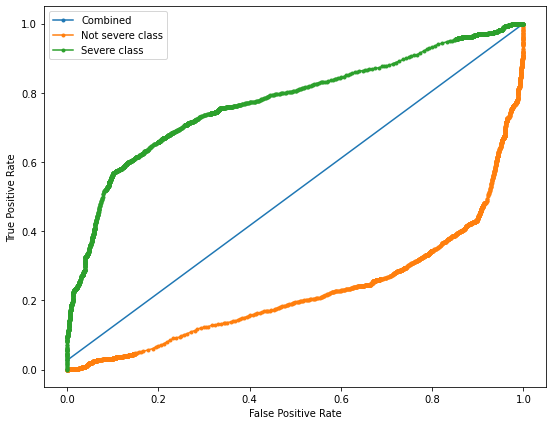

In [81]:
model_predict(LogisticRegression(random_state=0,C=1),x_train_scaled,x_test_scaled,y_train,y_test)

#### 6.1.2 With no one hot encoding or scaling

Combined ROC AUC=0.555
Severe class ROC AUC=0.779
Not severe class ROC AUC=0.221
ROC AUC:  0.7794145590707002
Accuracy:  0.9359225731091736
Precision:  0.8068669527896996
Recall:  0.11197141155449672
F1 score:  0.19665271966527195


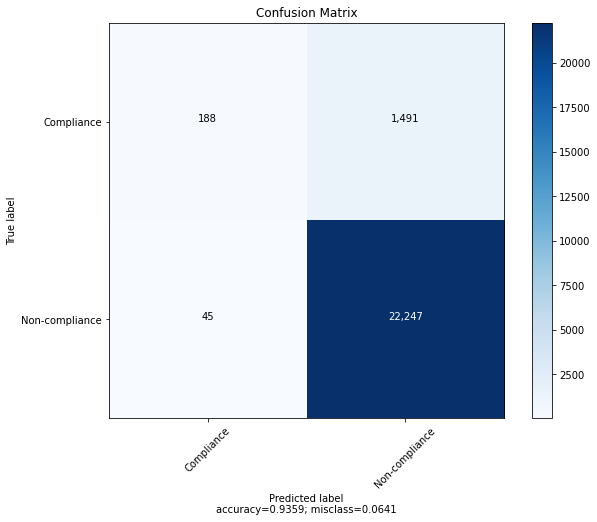

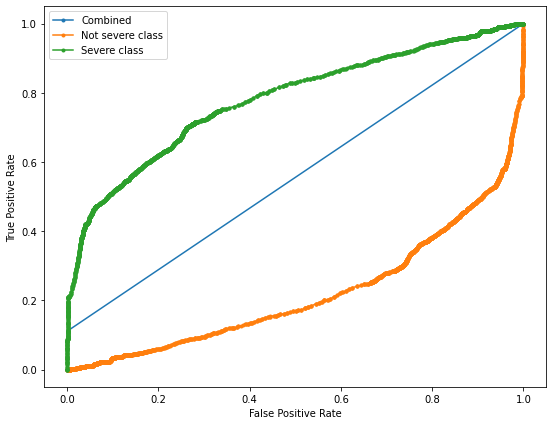

In [82]:
model_predict(LogisticRegression(random_state=0,C=1),x_train,x_test,y_train,y_test)

#### 6.1.3 With one hot encoding but no scaling

Combined ROC AUC=0.568
Severe class ROC AUC=0.796
Not severe class ROC AUC=0.204
ROC AUC:  0.795708126275039
Accuracy:  0.93863418297109
Precision:  0.9094488188976378
Recall:  0.1375818939845146
F1 score:  0.2390067252974651


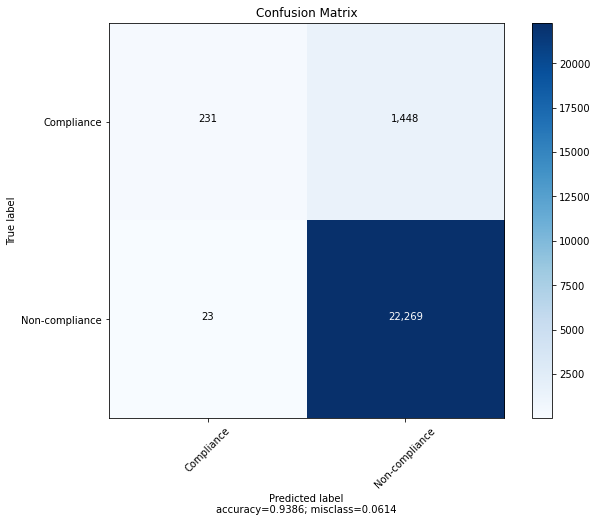

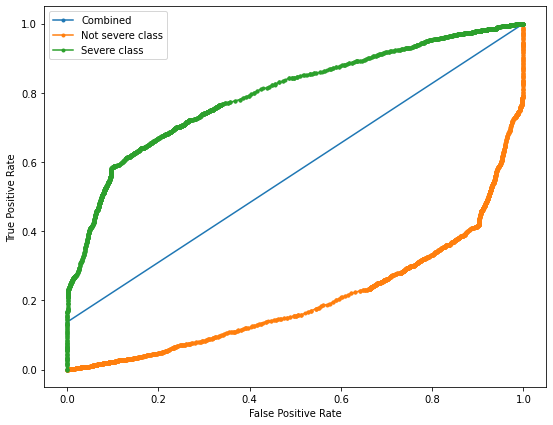

In [83]:
model_predict(LogisticRegression(random_state=0,C=1),x_train_preprocessed,x_test_preprocessed,y_train,y_test)

In [50]:
print (x_train_scaled)

[[0.025      0.         0.02765186 ... 0.         0.         0.        ]
 [0.005      0.         0.00770626 ... 1.         0.         0.        ]
 [0.1        0.         0.10244787 ... 1.         0.         0.        ]
 ...
 [0.025      0.         0.02765186 ... 0.         0.         0.        ]
 [0.25       0.         0.25203989 ... 1.         0.         0.        ]
 [0.05       0.         0.05258386 ... 0.         0.         0.        ]]


### 6.2 Decision Trees 

Combined ROC AUC=0.628
Severe class ROC AUC=0.713
Not severe class ROC AUC=0.287
ROC AUC:  0.7133111262321836
Accuracy:  0.9408451879354219
Precision:  0.709470304975923
Recall:  0.26325193567599764
F1 score:  0.3840139009556907


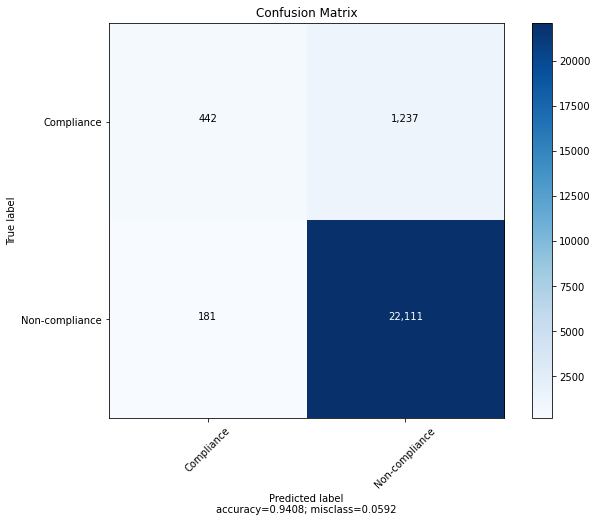

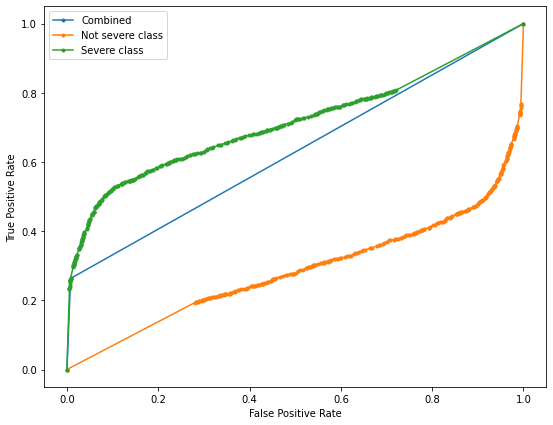

In [84]:
model_predict(DecisionTreeClassifier(random_state=0),x_train,x_test,y_train,y_test)

### 6.3 Random Forest

Combined ROC AUC=0.639
Severe class ROC AUC=0.754
Not severe class ROC AUC=0.246
ROC AUC:  0.7536380523939821
Accuracy:  0.9416378123565976
Precision:  0.7040816326530612
Recall:  0.2876712328767123
F1 score:  0.40845665961945027


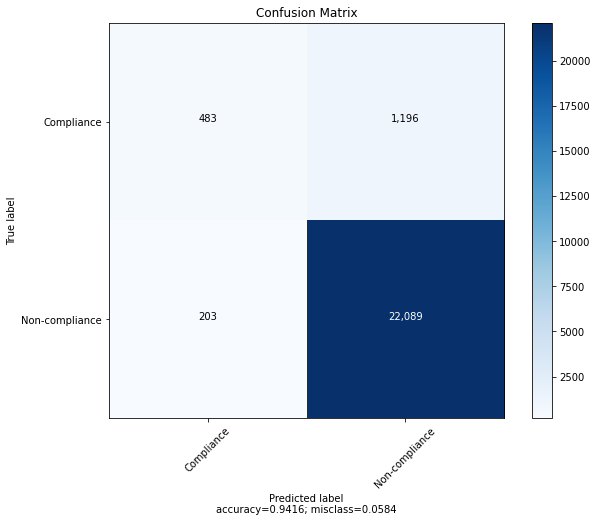

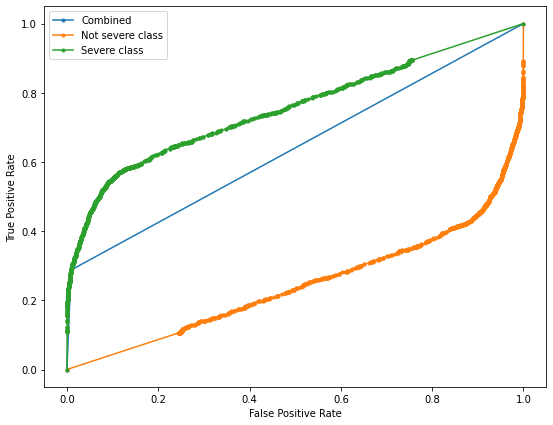

In [85]:
model_predict(RandomForestClassifier(random_state=0),x_train,x_test,y_train,y_test)

#### 6.4 Gradient Boosting

Combined ROC AUC=0.602
Severe class ROC AUC=0.804
Not severe class ROC AUC=0.196
ROC AUC:  0.8039973289707126
Accuracy:  0.9431396270493513
Precision:  0.9224598930481284
Recall:  0.2054794520547945
F1 score:  0.33609352167559664


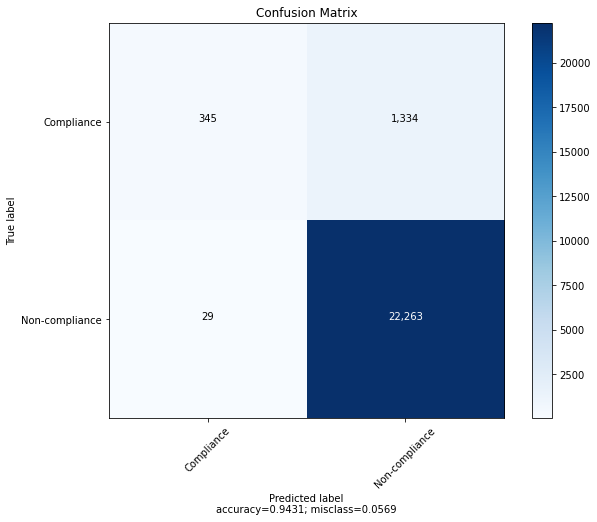

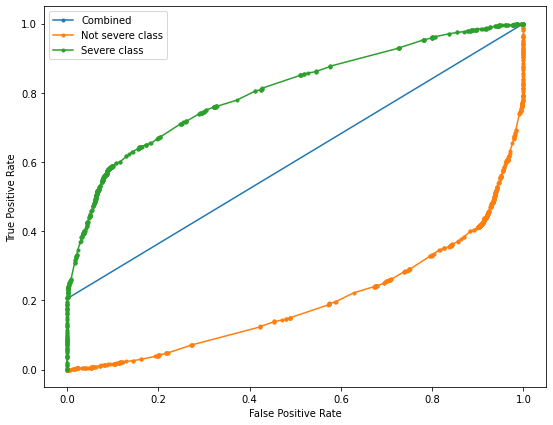

In [86]:
model_predict(GradientBoostingClassifier(random_state=0),x_train,x_test,y_train,y_test)

### 6.5 LightGBM

Combined ROC AUC=0.619
Severe class ROC AUC=0.803
Not severe class ROC AUC=0.197
ROC AUC:  0.8029839906030384
Accuracy:  0.944933461265696
Precision:  0.901565995525727
Recall:  0.24002382370458605
F1 score:  0.3791157102539981


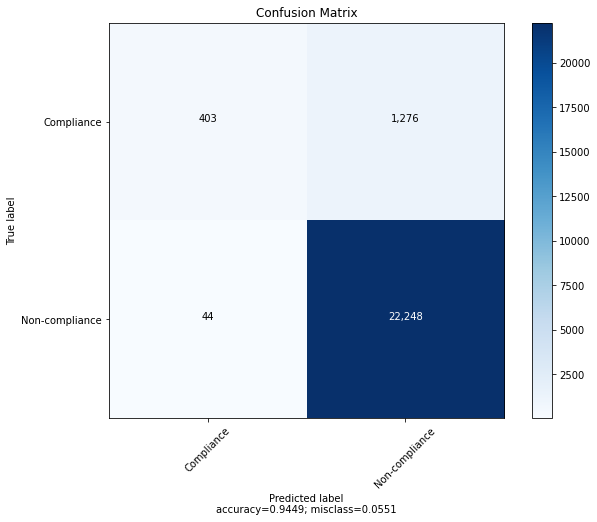

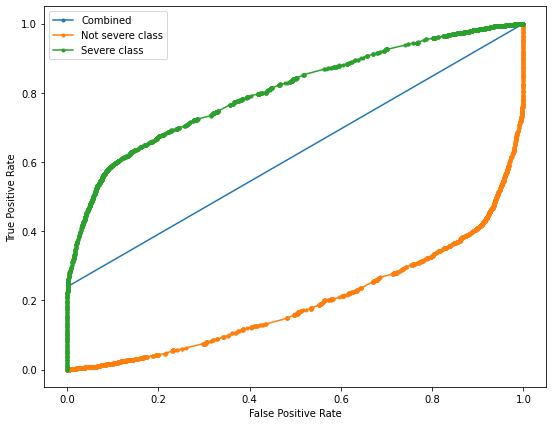

In [88]:
model_predict(LGBMClassifier(random_state=0),x_train,x_test,y_train,y_test)